In [1]:
import tensorflow as tf

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.0.0


In [ ]:
多输出：
比如衣服我们希望是红色、衬衣什么的

In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [4]:
data_dir = './dataset/moc'

In [5]:
data_root = pathlib.Path(data_dir)

In [6]:
data_root

WindowsPath('dataset/moc')

In [7]:
for item in data_root.iterdir():
    print(item)

dataset\moc\black_jeans
dataset\moc\black_shoes
dataset\moc\blue_dress
dataset\moc\blue_jeans
dataset\moc\blue_shirt
dataset\moc\red_dress
dataset\moc\red_shirt


In [8]:
all_image_paths = list(data_root.glob('*/*'))

In [9]:
image_count = len(all_image_paths)
image_count

2525

In [10]:
all_image_paths[:3]

[WindowsPath('dataset/moc/black_jeans/00000000.jpg'),
 WindowsPath('dataset/moc/black_jeans/00000001.jpeg'),
 WindowsPath('dataset/moc/black_jeans/00000002.jpeg')]

In [11]:
all_image_paths[-3:]

[WindowsPath('dataset/moc/red_shirt/00000383.jpg'),
 WindowsPath('dataset/moc/red_shirt/00000386.jpeg'),
 WindowsPath('dataset/moc/red_shirt/00000388.jpg')]

In [12]:
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [13]:
all_image_paths[:5]

['dataset\\moc\\blue_dress\\00000279.jpg',
 'dataset\\moc\\blue_jeans\\00000100.jpg',
 'dataset\\moc\\blue_dress\\00000293.jpg',
 'dataset\\moc\\red_shirt\\00000360.jpeg',
 'dataset\\moc\\black_shoes\\00000125.jpg']

In [14]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']

In [15]:
color_label_names = set(name.split('_')[0] for name in label_names)
color_label_names

{'black', 'blue', 'red'}

In [16]:
item_label_names = set(name.split('_')[1] for name in label_names)
item_label_names

{'dress', 'jeans', 'shirt', 'shoes'}

In [17]:
color_label_to_index = dict((name, index) for index,name in enumerate(color_label_names))
color_label_to_index

{'blue': 0, 'black': 1, 'red': 2}

In [18]:
item_label_to_index = dict((name, index) for index,name in enumerate(item_label_names))
item_label_to_index

{'jeans': 0, 'shoes': 1, 'dress': 2, 'shirt': 3}

In [19]:
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]
all_image_labels[:5]

['blue_dress', 'blue_jeans', 'blue_dress', 'red_shirt', 'black_shoes']

In [20]:
color_labels = [color_label_to_index[label.split('_')[0]] for label in all_image_labels]

In [21]:
color_labels[:5]

[0, 0, 0, 2, 1]

In [22]:
item_labels = [item_label_to_index[label.split('_')[1]] for label in all_image_labels]

In [23]:
item_labels[:10]

[2, 0, 2, 3, 1, 3, 2, 0, 0, 3]

In [24]:
import IPython.display as display

def caption_image(label):
    return {0: 'airplane', 1: 'lake'}.get(label)

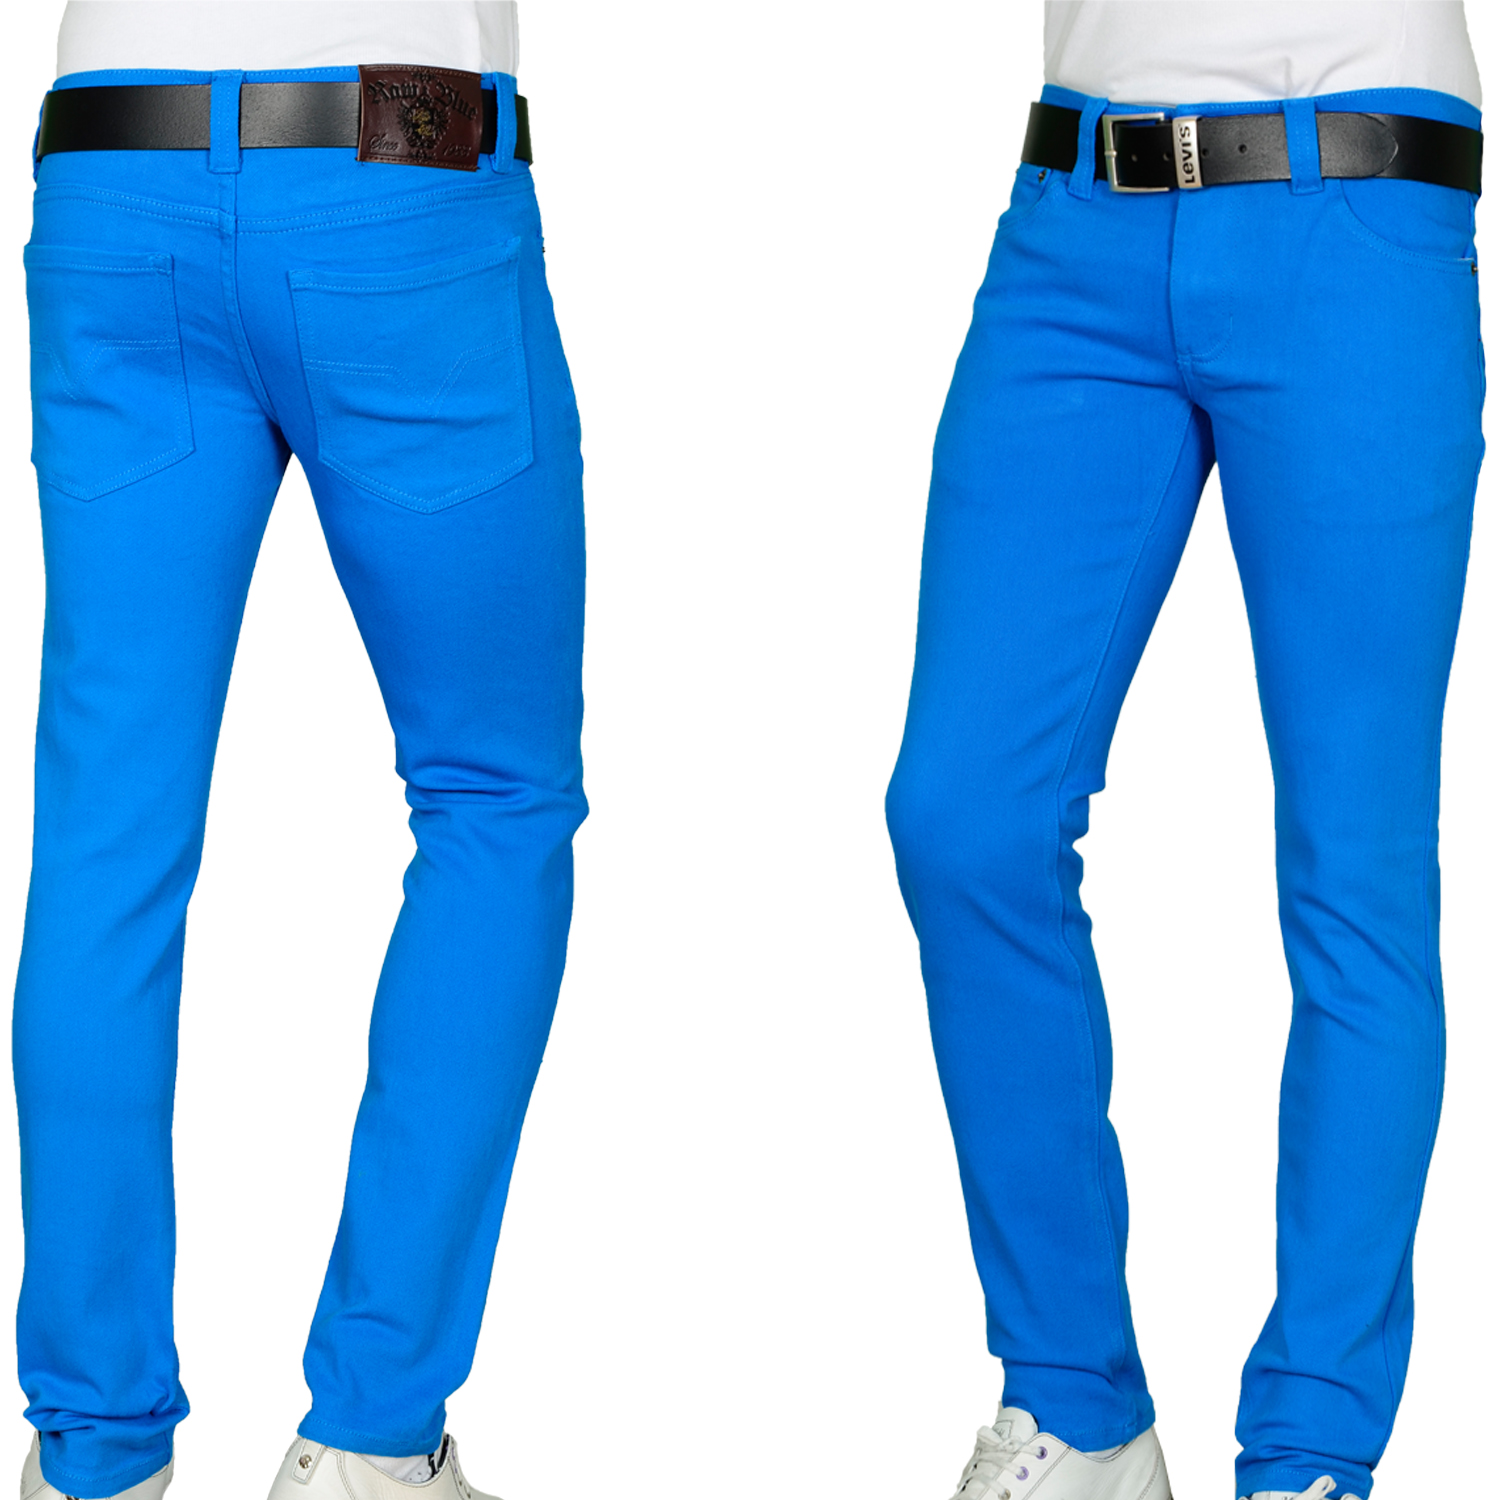

blue_jeans



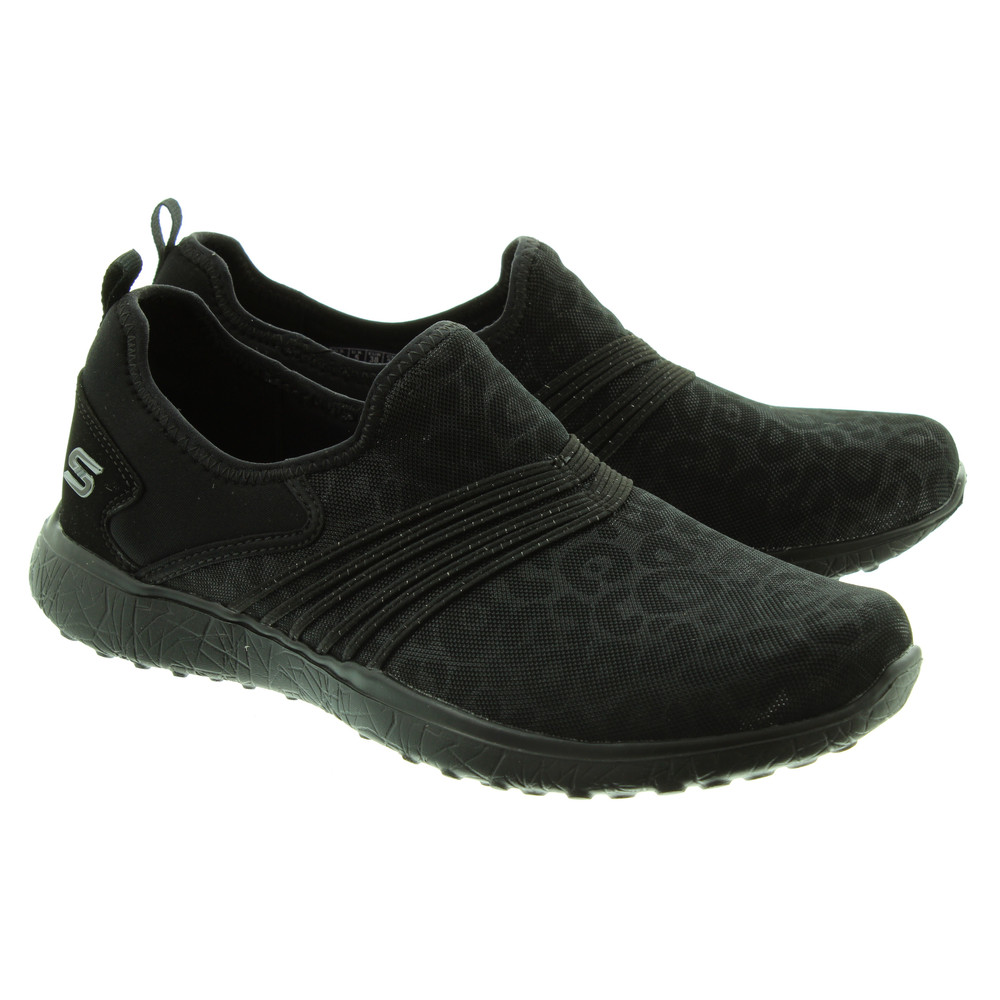

black_shoes



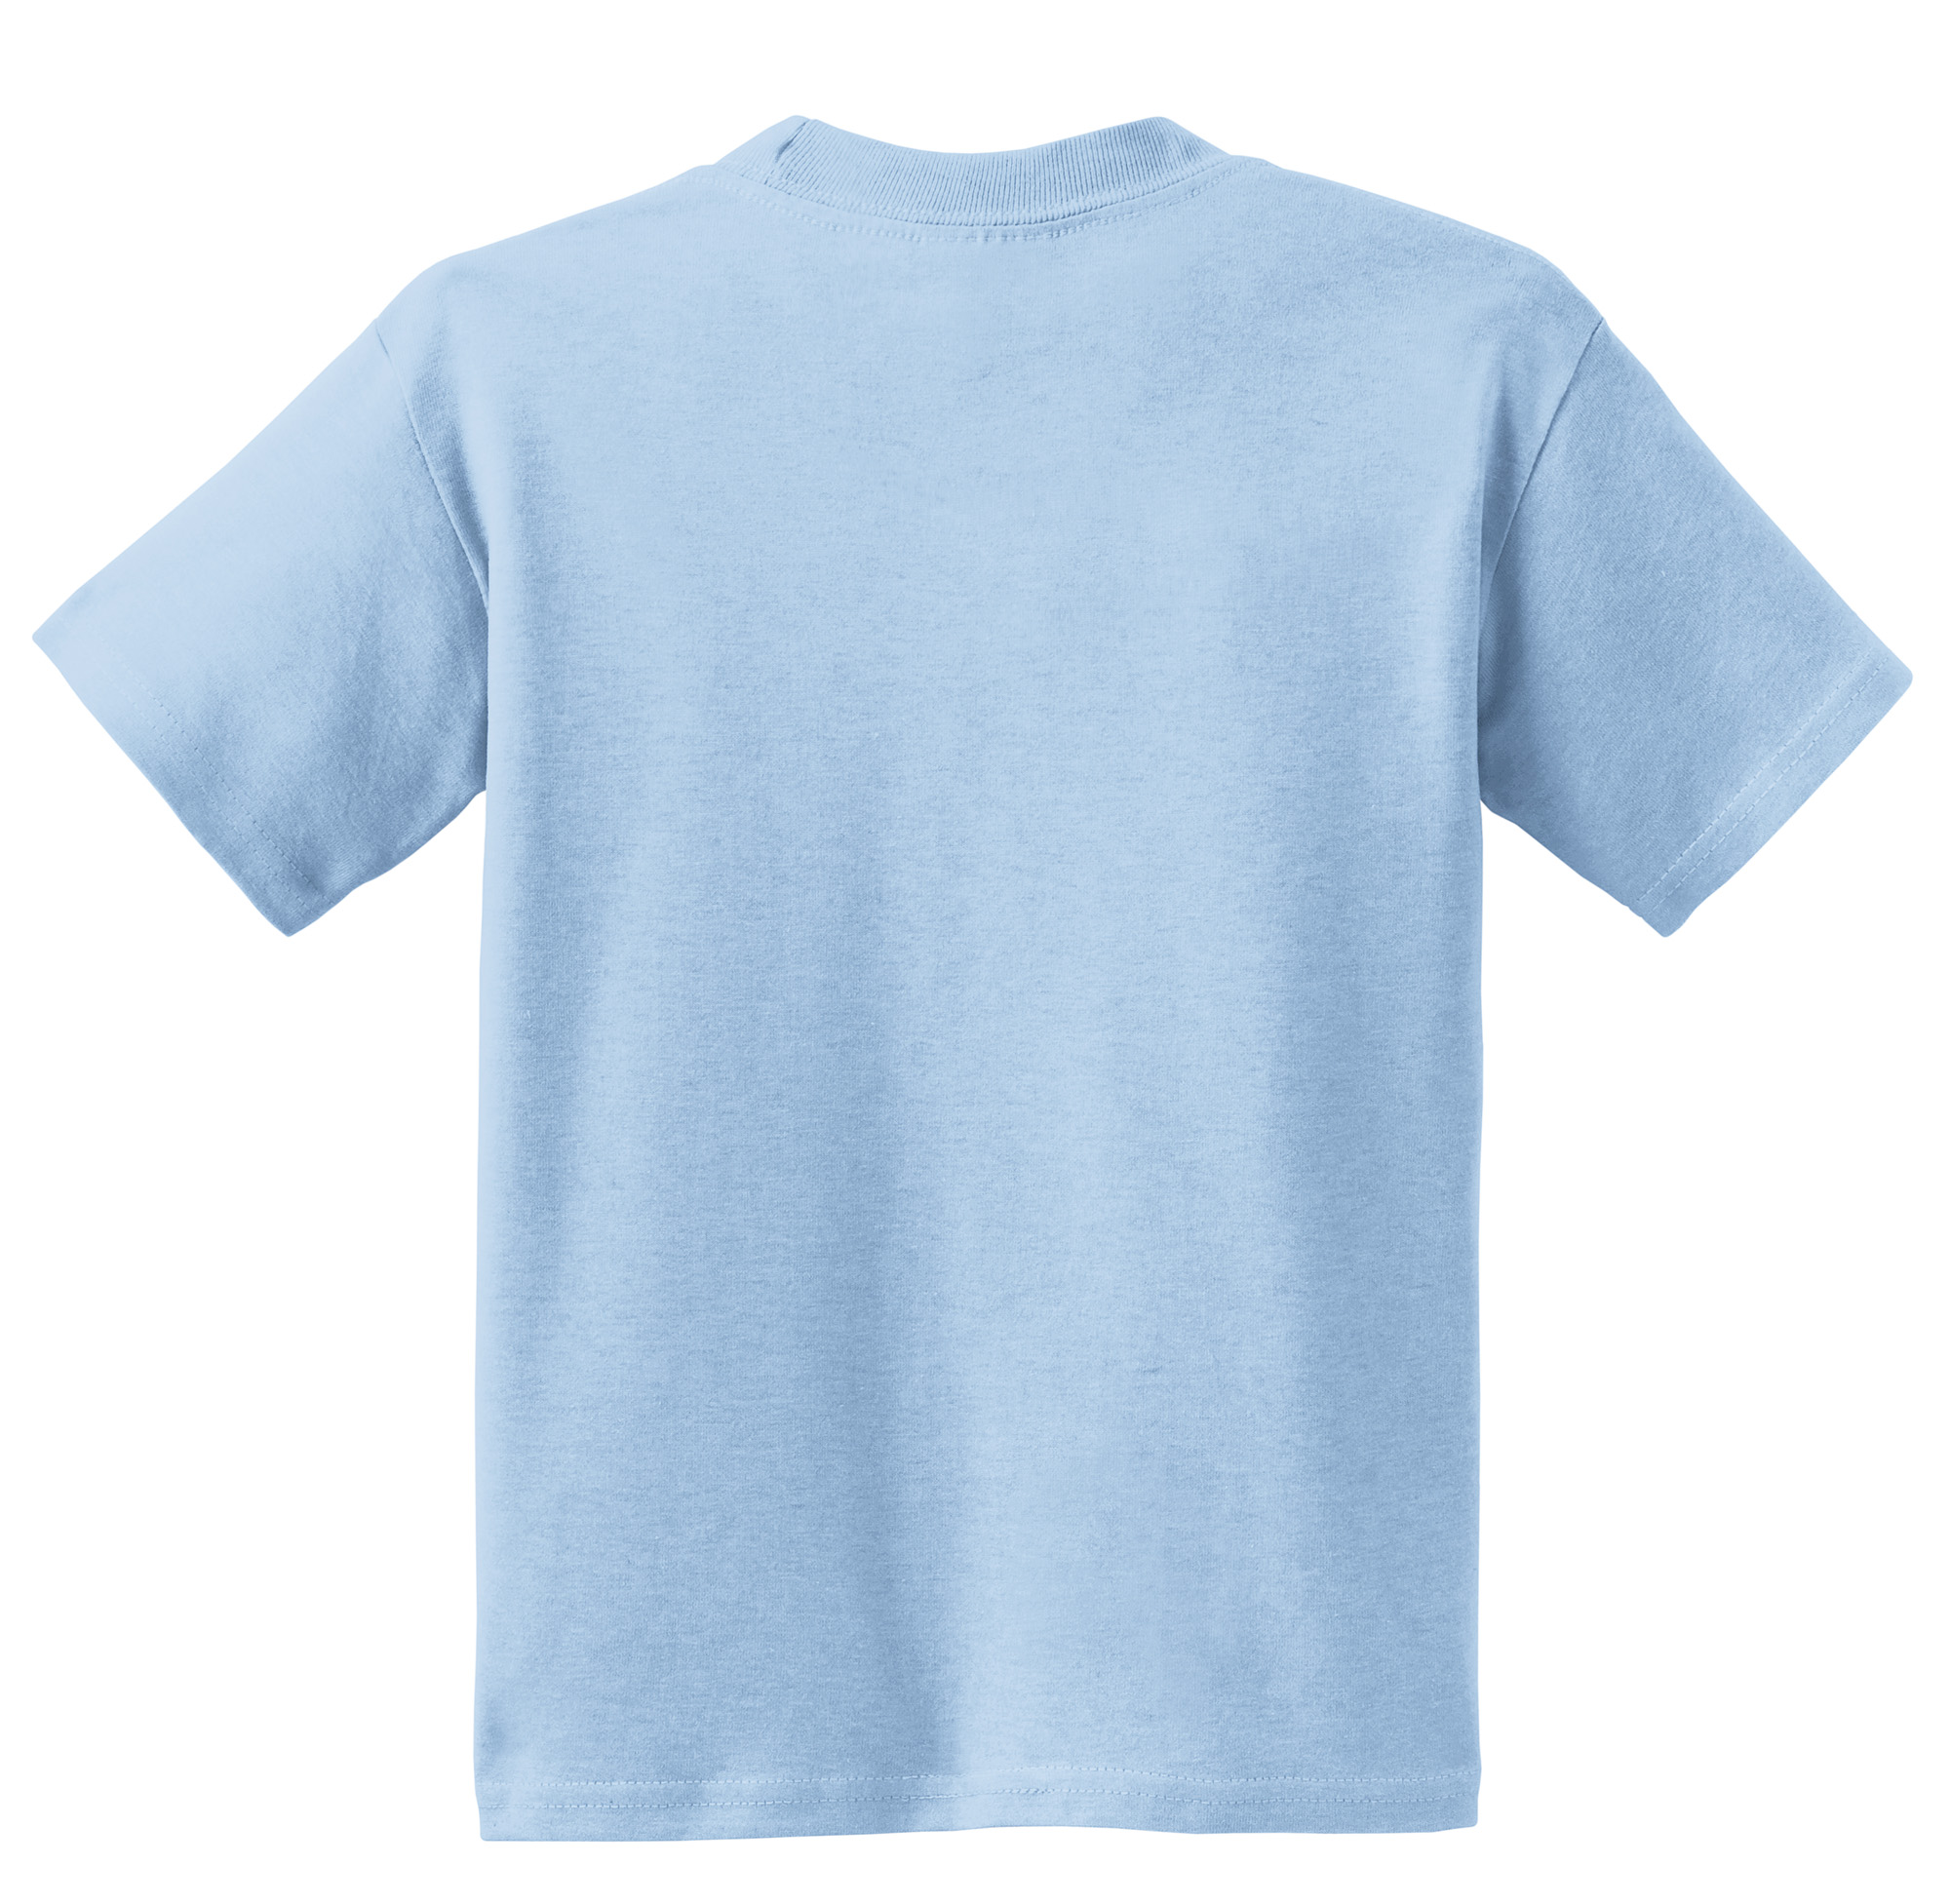

blue_shirt



In [25]:
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index], width=100, height=100))
    print(all_image_labels[image_index])
    print()

加载和格式化图像

In [26]:
img_path = all_image_paths[0]
img_path

'dataset\\moc\\blue_dress\\00000279.jpg'

In [27]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\...


In [28]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(2857, 1905, 3)
<dtype: 'uint8'>


In [29]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_tensor = tf.image.resize(img_tensor, [224, 224])
img_final = img_tensor/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
0.97608197


In [30]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    image = 2*image-1 #归一化到-1，1之间
    return image

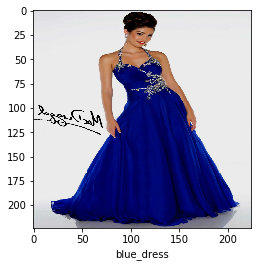

In [31]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow((load_and_preprocess_image(img_path) + 1)/2)
plt.grid(False)
plt.xlabel(label)
print()

In [32]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [34]:
label_ds = tf.data.Dataset.from_tensor_slices((color_labels, item_labels))

In [35]:
for ele in label_ds.take(3):
    print(ele[0].numpy(), ele[1].numpy())
# 0 0 blue jeans

0 2
0 0
0 2


In [36]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [37]:
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

In [38]:
test_count = int(image_count*0.2)
train_count = image_count - test_count

In [39]:
train_data = image_label_ds.skip(test_count)

test_data = image_label_ds.take(test_count)

In [40]:
BATCH_SIZE = 16

In [41]:
# mode.fit 需要重复，-1是一直重复
train_data = train_data.shuffle(buffer_size=train_count).repeat(-1)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [42]:
test_data = test_data.batch(BATCH_SIZE)

# 建立模型

In [43]:

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), 
                                               include_top=False,
                                               weights='imagenet')

In [44]:
mobile_net.trianable = False

In [45]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [46]:
x = mobile_net(inputs)

In [47]:
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [48]:
# x = mobile_net(inputs) 输出形状是4维 需要变成2维
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [49]:
x.get_shape()

TensorShape([None, 1280])

In [50]:
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_color = tf.keras.layers.Dense(len(color_label_names), 
                                  activation='softmax',
                                  name='out_color')(x1)

In [51]:
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_item = tf.keras.layers.Dense(len(item_label_names), 
                                 activation='softmax',
                                 name='out_item')(x2)

In [52]:
model = tf.keras.Model(inputs=inputs,
                       outputs=[out_color, out_item])

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1311744     global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [54]:
# 如果每个所用的损失函数不一样的话可以使用这个 name命名后的选定 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'out_color':'sparse_categorical_crossentropy',
                    'out_item':'sparse_categorical_crossentropy'},
              metrics=['acc']
)

In [55]:
train_steps = train_count//BATCH_SIZE
test_steps = test_count//BATCH_SIZE

In [56]:
model.fit(train_data,
          epochs=15,
          steps_per_epoch=train_steps,
          validation_data=test_data,
          validation_steps=test_steps
)

Train for 126 steps, validate for 31 steps
Epoch 1/15
126/126 [==============================] - 88s 696ms/step - loss: 0.3812 - out_color_loss: 0.1934 - out_item_loss: 0.1878 - out_color_acc: 0.9246 - out_item_acc: 0.9380 - val_loss: 0.1560 - val_out_color_loss: 0.0941 - val_out_item_loss: 0.0620 - val_out_color_acc: 0.9758 - val_out_item_acc: 0.9778
Epoch 2/15
126/126 [==============================] - 79s 629ms/step - loss: 0.0737 - out_color_loss: 0.0376 - out_item_loss: 0.0362 - out_color_acc: 0.9861 - out_item_acc: 0.9916 - val_loss: 0.1585 - val_out_color_loss: 0.0991 - val_out_item_loss: 0.0594 - val_out_color_acc: 0.9496 - val_out_item_acc: 0.9798
Epoch 3/15
126/126 [==============================] - 81s 641ms/step - loss: 0.0613 - out_color_loss: 0.0459 - out_item_loss: 0.0154 - out_color_acc: 0.9831 - out_item_acc: 0.9945 - val_loss: 0.2673 - val_out_color_loss: 0.1787 - val_out_item_loss: 0.0886 - val_out_color_acc: 0.9456 - val_out_item_acc: 0.9819
Epoch 4/15
126/126 [====

In [57]:
# 评价这个模型
# verbose 0显示所有提示 1 x显示最主要的参数  2 不显示提示
model.evaluate(test_data)

32/32 [==============================] - 6s 197ms/step - loss: 0.0966 - out_color_loss: 0.0757 - out_item_loss: 0.0210 - out_color_acc: 0.9842 - out_item_acc: 0.9921


[0.09663068220493187, 0.07566769, 0.020963, 0.9841584, 0.9920792]

In [59]:
#  转义\
# 随机从我们数据集汇总选择进行测试
my_image = load_and_preprocess_image(r'{}'.format(random.choice(test_dir)))

In [62]:
# 三维数据不符合我们的模型
my_image.shape

TensorShape([224, 224, 3])

In [63]:
# 扩充维度
my_image = tf.expand_dims(my_image, 0)

In [64]:
my_image.shape

TensorShape([1, 224, 224, 3])

In [66]:
# 对三种color进行预测
pred = model.predict(my_image)

In [69]:
np.argmax(pred[0])

0

In [70]:
np.argmax(pred[1])

0

In [ ]:
pre_color  = index_to_color.get(np.argmax(pred[0][0]))
# 输出 black 颜色

In [ ]:
pre_iten  = index_to_color.get(np.argmax(pred[1][0]))
# 输出 牛仔裤 裤子

In [ ]:
pre = pre_color + '_' + pre_item

In [ ]:
plt.imshow((my_image[0] +1)/2)
plt.xlabel(pred)

In [ ]:
# 当然我们也可以直接用model
# False 预测模式的话，会使用训练集中的均值来预测
# TRUE单签数据集去计算移动均值
pre = model(my_image.training=True)